# Mean profile based moa prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [4]:
import pyarrow

# Data

In [52]:
try:
    paths = snakemake.input.paths
    labels_path = snakemake.input.labels
except NameError:
    data_dir = Path("/user/gent/420/vsc42015/vsc_data_vo/datasets/BBBC021/scip/")
    paths = data_dir.rglob("features.parquet")
    labels_path = data_dir.parent / "labels.parquet"

In [53]:
df = pandas.concat([pq.read_table(p).to_pandas() for p in paths])

In [54]:
labels = pq.read_table(labels_path).to_pandas()

In [55]:
df = df.merge(labels, left_on="meta_filename", right_on="meta_image_filename_dapi")

In [56]:
mu = df.groupby(["meta_compound", "meta_concentration"]).mean().filter(regex="feat")

In [58]:
mu = mu.merge(labels.set_index(["meta_compound", "meta_concentration"]), left_index=True, right_index=True).reset_index()

# Dimred

In [88]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import scale

In [82]:
dimred = PCA().fit_transform(scale(mu.filter(regex="feat")))

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


<AxesSubplot:>

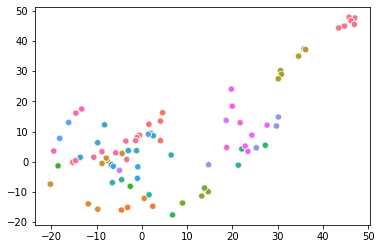

In [86]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=mu["meta_compound"], legend=None)

<AxesSubplot:>

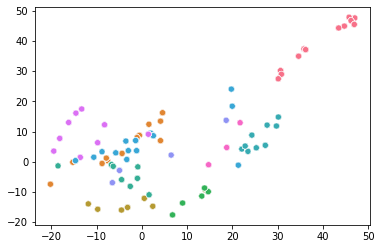

In [87]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=mu["meta_moa"], legend=None)

In [89]:
dimred = UMAP().fit_transform(scale(mu.filter(regex="feat")))

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:>

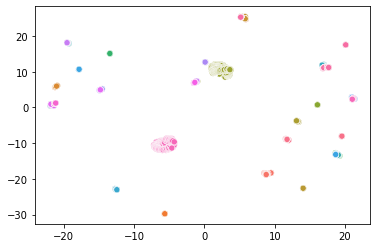

In [90]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=mu["meta_compound"], legend=None)

<AxesSubplot:>

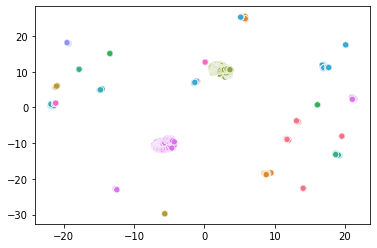

In [91]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=mu["meta_moa"], legend=None)

# Prediction

In [65]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.neighbors import KNeighborsClassifier

In [71]:
results = cross_validate(
    cv=LeaveOneGroupOut(),
    X=mu.filter(regex="feat"),
    y=mu["meta_moa"],
    groups=mu["meta_compound"],
    estimator=KNeighborsClassifier(n_neighbors=5),
    return_train_score=True
)